In [ ]:
import os
import random
from PIL import Image

import pathlib
import zipfile

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

from typing import Tuple, Dict, List

In [ ]:
!pip install -q torchinfo
from torchinfo import summary

In [ ]:
data_path = pathlib.Path("data/")
image_path = pathlib.Path("data/images")

if image_path.is_dir():
  print(f"[INFO] {image_path} already exists, skipping dowload.")
else:
  image_path.mkdir(parents = True, exist_ok = True)
  print(f"[INFO] {image_path} creating...")

with zipfile.ZipFile("data/flowers.zip", "r") as zip_file:
  zip_file.extractall(image_path)

[INFO] data/images already exists, skipping dowload.


In [ ]:
train_dir = pathlib.Path("data/images/flowers/train")
test_dir = pathlib.Path("data/images/flowers/test")

In [ ]:
train_dir, test_dir

(PosixPath('data/images/flowers/train'), PosixPath('data/images/flowers/test'))

In [ ]:
for dirpath, dirnames, filenames in os.walk(pathlib.Path("data/images/flowers")):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in data/images/flowers
There are 5 directories and 0 images in data/images/flowers/train
There are 0 directories and 780 images in data/images/flowers/train/tulip
There are 0 directories and 628 images in data/images/flowers/train/rose
There are 0 directories and 577 images in data/images/flowers/train/sunflower
There are 0 directories and 608 images in data/images/flowers/train/daisy
There are 0 directories and 848 images in data/images/flowers/train/dandelion
There are 5 directories and 0 images in data/images/flowers/test
There are 0 directories and 204 images in data/images/flowers/test/tulip
There are 0 directories and 156 images in data/images/flowers/test/rose
There are 0 directories and 156 images in data/images/flowers/test/sunflower
There are 0 directories and 156 images in data/images/flowers/test/daisy
There are 0 directories and 204 images in data/images/flowers/test/dandelion


In [ ]:
image_path_list = list(pathlib.Path("data/images/flowers").glob("*/*/*.jpg"))
len(image_path_list)

4317

Flower Image Class: dandelion


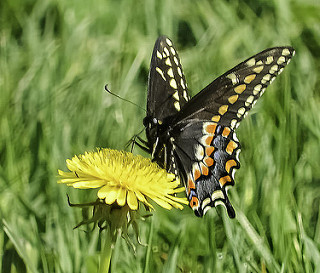

In [ ]:
random_flower_sample = random.choice(image_path_list)
flower_image = Image.open(random_flower_sample)
flower_image_class = random_flower_sample.parent.stem
print(f"Flower Image Class: {flower_image_class}")
flower_image

(np.float64(-0.5), np.float64(319.5), np.float64(272.5), np.float64(-0.5))

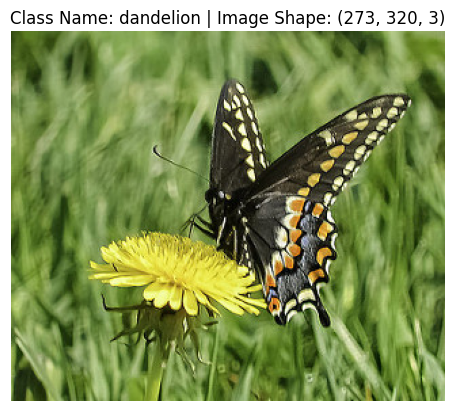

In [ ]:
image_array = np.asarray(flower_image)
plt.figure()
plt.imshow(image_array)
plt.title(f"Class Name: {random_flower_sample.parent.stem} | Image Shape: {image_array.shape}")
plt.axis("off")

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

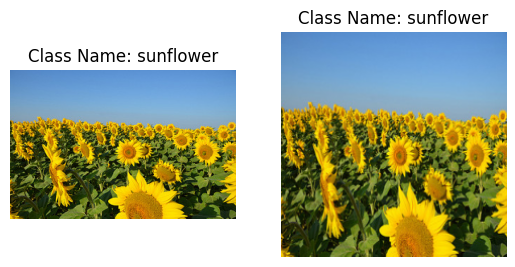

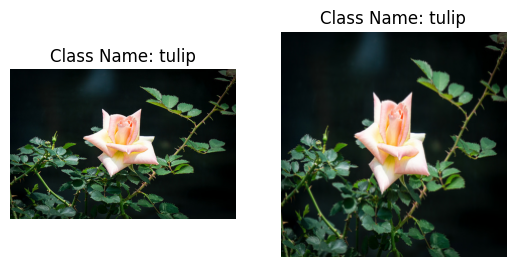

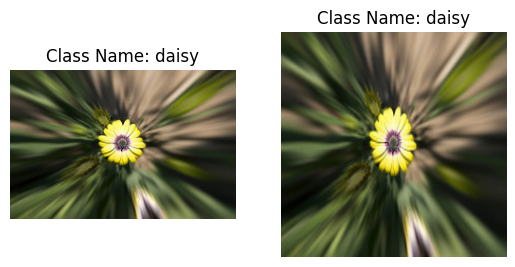

In [ ]:
random_flower_images = random.sample(image_path_list, k = 3)
for random_flower_image in random_flower_images:
  with Image.open(random_flower_image) as flower_image:
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(flower_image)
    axes[0].set_title(f"Class Name: {random_flower_image.parent.stem}")
    axes[0].axis("off")

    transformed_image = transform(flower_image).permute(1, 2, 0)
    axes[1].imshow(transformed_image)
    axes[1].set_title(f"Class Name: {random_flower_image.parent.stem}")
    axes[1].axis("off")

In [ ]:
# torchvision.datasets.ImageFolder(root,  transform)

class ImageFolder(torch.utils.data.Dataset):
  def __init__(self, root, transform):
    self.path = list(pathlib.Path(root).glob("*/*.jpg"))
    self.transform = transform
    self.classes = sorted([empty.name for empty in os.scandir(root)])
    self.class_to_idx = {class_name : i for i, class_name in enumerate(self.classes)}

  def load_image(self, index):
    image = self.path[index]
    return Image.open(image)

  def __len__(self):
    return len(self.path)

  def __getitem__(self, index):
    image = self.load_image(index)
    class_name = self.path[index].parent.stem    # {'daisy', 'dandelion', ....}
    class_to_idx = self.class_to_idx[class_name] # {'daisy' : 0, 'dandelion' : 1, ...}

    if self.transform:
      return self.transform(image), class_to_idx
    else:
      return image, class_to_idx

In [ ]:
custom_flowers_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
])

In [ ]:
train_set = ImageFolder(root = pathlib.Path("data/images/flowers/train"), transform = custom_flowers_transform)
test_set = ImageFolder(root = pathlib.Path("data/images/flowers/test"), transform = custom_flowers_transform)

In [ ]:
train_set.classes, train_set.class_to_idx

(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'],
 {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4})

In [ ]:
test_set.classes, test_set.class_to_idx

(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'],
 {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4})

In [ ]:
# display random images
# select random idx
def display_images(dataset, classes, n = 5):
  random_flowers_idx = random.sample(range(len(dataset)), k = n)
  plt.figure(figsize = (15, 6))
  for i, target_sample in enumerate(random_flowers_idx):
    images, labels = dataset[target_sample][0], dataset[target_sample][1]
    plt.subplot(1, n, i+1)

    target_image = images.permute(1, 2, 0)
    plt.imshow(target_image)
    plt.axis("off")
    if classes:
      title = f"Class Name: {classes[labels]}"
    plt.title(title)

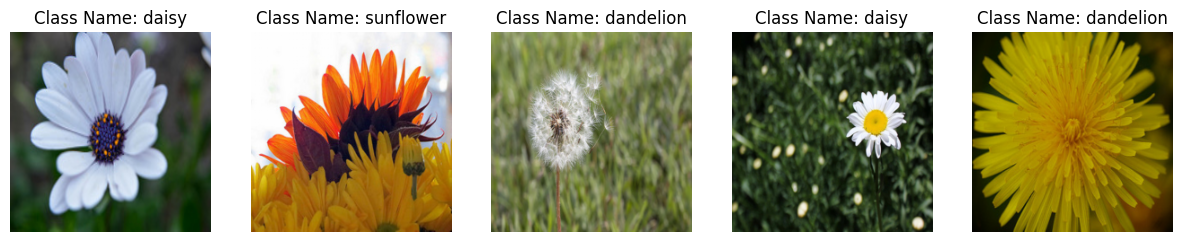

In [ ]:
display_images(dataset = train_set, classes = train_set.classes)

In [ ]:
def create_pretrained_model(classes : int = 5):
  weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
  transform = weights.transforms()
  model = torchvision.models.efficientnet_b0(weights = weights)

  for param in model.parameters():
    param.requires_grad = False

  model.classifier = torch.nn.Sequential(
      torch.nn.Dropout(p = 0.3),
      torch.nn.Linear(in_features = 1280, out_features = 5)
  )
  return model, transform

In [ ]:
flowers_model, flowers_transform = create_pretrained_model()

In [ ]:
flowers_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
summary(model = flowers_model,
        input_size = (1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 5]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
flowers_train_transforms = transforms.Compose([
    transforms.TrivialAugmentWide(),
    flowers_transform
])

In [ ]:
flowers_train_set = ImageFolder(root = pathlib.Path("data/images/flowers/train"), transform = flowers_train_transforms)
flowers_test_set = ImageFolder(root = pathlib.Path("data/images/flowers/test"), transform = flowers_transform)

In [ ]:
batch_size = 32
num_workers = os.cpu_count()

flowers_train_dataLoader = torch.utils.data.DataLoader(dataset = flowers_train_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)
flowers_test_dataLoader = torch.utils.data.DataLoader(dataset = flowers_test_set, batch_size = batch_size, shuffle = False, num_workers = num_workers)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(flowers_model.parameters(), lr = 0.001)

In [ ]:
def train_step(model : torch.nn.Module,
               train_dataLoader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               device : torch.device):

  total_train_loss, total_train_acc = 0, 0
  model.train()
  for batch, (X, y) in enumerate(train_dataLoader):
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    train_logits = model(X)
    train_loss = loss_fn(train_logits, y)
    total_train_loss += train_loss.item()
    train_loss.backward()
    optimizer.step()

    train_labels = torch.argmax(torch.softmax(train_logits, dim = 1), dim = 1)
    total_train_acc += (train_labels == y).sum().item() / len(train_labels)

  total_train_loss = total_train_loss / len(train_dataLoader)
  total_train_acc = total_train_acc / len(train_dataLoader)

  return total_train_loss, total_train_acc*100

def test_step(model : torch.nn.Module,
              test_dataLoader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              device : torch.device):

  total_test_loss, total_test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataLoader):
      X, y = X.to(device), y.to(device)
      test_logits = model(X)
      test_loss = loss_fn(test_logits, y)
      total_test_loss += test_loss.item()

      test_labels = torch.argmax(torch.softmax(test_logits, dim = 1), dim = 1)
      total_test_acc += (test_labels == y).sum().item() / len(test_labels)

    total_test_loss = total_test_loss / len(test_dataLoader)
    total_test_acc = total_test_acc / len(test_dataLoader)

  return total_test_loss, total_test_acc*100

def train_test(model : torch.nn.Module,
               train_dataLoader : torch.utils.data.DataLoader,
               test_dataLoader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               epochs : int,
               device : torch.device):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  model.to(device)

  for epoch in range(epochs):
    train_loss, train_acc = train_step(model = model,
                                       train_dataLoader = train_dataLoader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)

    test_loss, test_acc = test_step(model = model,
                                    test_dataLoader = test_dataLoader,
                                    loss_fn = loss_fn,
                                    device = device)

    print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [ ]:
flowers_result = train_test(model = flowers_model,
                            train_dataLoader = flowers_train_dataLoader,
                            test_dataLoader = flowers_test_dataLoader,
                            loss_fn = loss_fn,
                            optimizer = optimizer,
                            epochs = 5,
                            device = "cuda" if torch.cuda.is_available() else "cpu")

flowers_result

Epoch: 1 | train_loss: 0.8631 | train_acc: 72.8435 | test_loss: 0.4349 | test_acc: 88.9881
Epoch: 2 | train_loss: 0.5536 | train_acc: 81.7776 | test_loss: 0.3477 | test_acc: 89.7693
Epoch: 3 | train_loss: 0.4849 | train_acc: 83.2499 | test_loss: 0.3161 | test_acc: 90.5506
Epoch: 4 | train_loss: 0.4495 | train_acc: 83.7997 | test_loss: 0.3038 | test_acc: 89.6577
Epoch: 5 | train_loss: 0.4336 | train_acc: 84.5299 | test_loss: 0.2963 | test_acc: 89.7693


{'train_loss': [0.863093926122895,
  0.5536116907993952,
  0.48486553380886716,
  0.44953753302494687,
  0.4336355499647282],
 'train_acc': [72.84347766884531,
  81.77764161220043,
  83.24993191721133,
  83.79970043572985,
  84.52988834422658],
 'test_loss': [0.43490722083619665,
  0.3476542681455612,
  0.31609549772526535,
  0.30380504205822945,
  0.2962579328034605],
 'test_acc': [88.98809523809524,
  89.76934523809524,
  90.55059523809524,
  89.6577380952381,
  89.76934523809524]}

In [ ]:
def plot_loss_curves(results):
  train_loss = results["train_loss"]
  train_acc = results["train_acc"]
  test_loss = results["test_loss"]
  test_acc = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label = "train loss")
  plt.plot(epochs, test_loss, label = "test loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label = "train acc")
  plt.plot(epochs, test_acc, label = "test acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

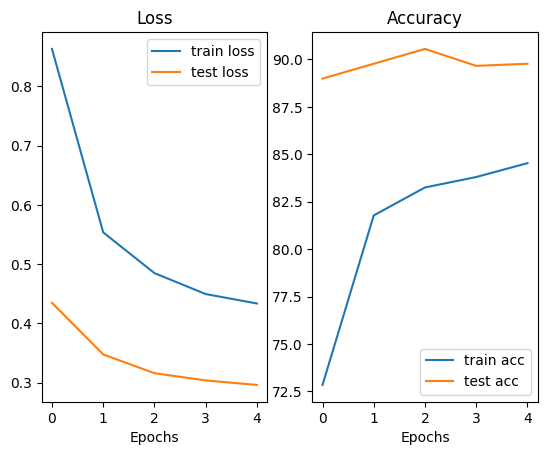

In [ ]:
plot_loss_curves(flowers_result)

In [ ]:
def save_model(model : torch.nn.Module,
               target_dir : str,
               model_name : str):

  target_dir_path = pathlib.Path(target_dir)
  target_dir_path.mkdir(parents = True, exist_ok = True)

  assert model_name.endswith('.pth') or model_name.endswith('.pt'), "model name should end with '.pth' or '.pt'."

  model_save_path = target_dir_path / model_name

  print(f"[INFO] Saving model to: {model_save_path}.")
  torch.save(obj = model.state_dict(),
             f = model_save_path)

In [ ]:
save_model(model = flowers_model, target_dir = "model", model_name = "pretrained_effnet_b0_flowers.pth")

[INFO] Saving model to: model/pretrained_effnet_b0_flowers.pth.


In [ ]:
model_size = pathlib.Path("model/pretrained_effnet_b0_flowers.pth").stat().st_size // (1024 * 1024)
print(f"Model Size: {model_size} MB.")

Model Size: 15 MB.


In [ ]:
flowers_demo_path = pathlib.Path("demos/flowers")
flowers_demo_path.mkdir(parents = True, exist_ok = True)

flowers_demo_examples_path = flowers_demo_path / "examples"
flowers_demo_examples_path.mkdir(parents = True, exist_ok = True)

In [ ]:
import shutil
flowers = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
flowers_path = pathlib.Path("data/images/flowers/test")
all_images = []

for flower in flowers:
  flower_path = flowers_path / flower
  flower_image = list(flower_path.glob("*.jpg"))
  random_flowers_image = random.choice(flower_image)
  all_images.append(random_flowers_image)

for random_image in all_images:
  destination = flowers_demo_examples_path / random_image.name
  print(f"[INFO] Copying {random_image} to {destination}")
  shutil.copy2(src = random_image, dst = destination)

[INFO] Copying data/images/flowers/test/daisy/163978992_8128b49d3e_n.jpg to demos/flowers/examples/163978992_8128b49d3e_n.jpg
[INFO] Copying data/images/flowers/test/dandelion/2522454811_f87af57d8b.jpg to demos/flowers/examples/2522454811_f87af57d8b.jpg
[INFO] Copying data/images/flowers/test/rose/3065719996_c16ecd5551.jpg to demos/flowers/examples/3065719996_c16ecd5551.jpg
[INFO] Copying data/images/flowers/test/sunflower/2425164088_4a5d2cdf21_n.jpg to demos/flowers/examples/2425164088_4a5d2cdf21_n.jpg
[INFO] Copying data/images/flowers/test/tulip/4516198427_0e5099cd8e.jpg to demos/flowers/examples/4516198427_0e5099cd8e.jpg


In [ ]:
!cp model/pretrained_effnet_b0_flowers.pth demos/flowers

In [ ]:
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

In [ ]:
%%writefile demos/flowers/model.py

import torch
import torch.nn
import torchvision
import torchvision.transforms

def create_pretrained_model(classes : int = 5):
  weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
  transform = weights.transforms()
  model = torchvision.models.efficientnet_b0(weights = weights)

  for param in model.parameters():
    param.requires_grad = False

  model.classifier = torch.nn.Sequential(
      torch.nn.Dropout(p = 0.3),
      torch.nn.Linear(in_features = 1280, out_features = 5)
  )
  return model, transform

Overwriting demos/flowers/model.py


In [ ]:
%%writefile demos/flowers/app.py

import gradio as gr
import os
import torch

from model import create_pretrained_model
from timeit import default_timer as timer
from typing import Tuple, Dict

flowers_model, flowers_transform = create_pretrained_model()

class_names = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

flowers_model.load_state_dict(
    torch.model(
        f = "pretrained_effnet_b0_flowers.pth",
        map_location = torch.device("cpu")
    )
)

def predict(img) -> Tuple[Dict, float]:
  start_time = timer()

  img = flowers_transform(img).unsqueeze(dim = 0)
  flowers_model.eval()
  with torch.inference_mode():
      y_logit = flowers_model(img)
      y_prob = torch.softmax(y_logit, dim = 1)

  pred_labels_and_probs = {class_names[i] : float(y_prob[0][i]) for i in range(len(class_names))}
  end_time = timer()
  pred_time = round(end_time - start_time, 5)

  return pred_labels_and_probs, pred_time

title = "Flowers "
description = "An EfficientNetB0 feature extractor computer vision model to classify images of flowers."


example_list = [["examples/" + example] for example in os.listdir("examples")]

demo = gr.Interface(
    fn = predict,
    inputs = gr.Image(type = "pil"),
    outputs = [gr.Label(num_top_classes = 5, label = "Predictions"),
               gr.Number(label = "Prediction Time (s)")
              ],
    examples = example_list,
    title = title,
    description = description
)

demo.launch()

Overwriting demos/flowers/app.py


In [ ]:
%%writefile demos/flowers/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Overwriting demos/flowers/requirements.txt


In [ ]:
!cd demos/flowers && zip -r ../flowers.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 52%)
  adding: examples/ (stored 0%)
  adding: examples/163978992_8128b49d3e_n.jpg (deflated 0%)
  adding: examples/3065719996_c16ecd5551.jpg (deflated 1%)
  adding: examples/2425164088_4a5d2cdf21_n.jpg (deflated 1%)
  adding: examples/4516198427_0e5099cd8e.jpg (deflated 1%)
  adding: examples/2522454811_f87af57d8b.jpg (deflated 1%)
  adding: model.py (deflated 48%)
  adding: pretrained_effnet_b0_flowers.pth (deflated 8%)
  adding: requirements.txt (deflated 4%)


In [ ]:
try:
  from google.colab import files
  files.download("demos/flowers.zip")
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), please download manually.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>